In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import astropy.units as u
import astropy.constants as c
import astropy.cosmology.units as cu
from astropy.cosmology import Planck15 as cosmo
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.theory.DD import DD
from Corrfunc.utils import convert_3d_counts_to_cf
sys.path.insert(0, '/work/08811/aew492/ls6/small-scale_cross-corrs')
from illustris_sim import TNGSim
import corrfunc_ls
import tools

We can approximate the linear angular power spectrum as
$$
C(\ell) \approx \frac{\Delta\chi}{\chi^2(\bar z)}\,W_\mathrm{phot}(\chi)\,W_i\,b_\mathrm{phot}(\bar z)\,b_i(\bar z) \,P_\mathrm{lin}\left(k=\frac{\ell + 1/2}{\chi(\bar z)},\bar z\right)
$$

where $\chi$ is comoving distance and $\bar z$ is the redshift of the snapshot.

$W$ are the weights:
$$
W_\mathrm{phot} = \frac{1}{N_\mathrm{phot}}\frac{\mathrm{d}N_\mathrm{phot}}{\mathrm{d}\chi}
$$

$$
W_i = \frac{1}{\Delta\chi}\quad \mathrm{if}\quad -\frac{\Delta\chi}{2}+\chi_i\leq\chi\leq\chi_i + \frac{\Delta\chi}{2}
$$

$b$ is the linear bias which we can estimate from
$$
b = \frac{w_\mathrm{Gal\ x\ DM}(\theta)}{w_\mathrm{lin}(\theta)}
$$

### functions

In [3]:
def perh():
    return (cosmo.H(0.) / 100 * u.Mpc / u.km * u.s) / cu.littleh

In [4]:
def get_dx(z, sigma_z):
    return sigma_z * (1 + z) * c.c.to(u.km/u.s) / cosmo.H(z) * perh()

In [5]:
def eval_Gaussian(loc, sigma, mean=0.):
    # pre = 1 / (sigma * np.sqrt(2 * np.pi))
    pre = 1 / sigma.unit if hasattr(sigma, 'unit') else 1
    exp = -(loc-mean)**2 / (2 * sigma**2)
    return pre * np.e**exp

In [6]:
def redshift_to_comov(z, cosmo=cosmo):
    r = cosmo.comoving_distance(z) * perh() # convert to Mpc/h
    return r

In [7]:
# convert Cartesian (x,y,z) coords in the box to (RA,Dec) on the sky from our observer pos,
#   given the comoving distance to the box center
def CartesiantoEquatorial(pos, observer=[0,0,0]):
    x, y, z = (pos - np.array(observer)).T
    s = np.hypot(z, y) 
    lon = np.arctan2(y, z)
    lat = np.arctan2(x, s)

    # convert to degrees
    lon = np.rad2deg(lon)
    lat = np.rad2deg(lat)
    # wrap lon to [0,360]
    lon = np.mod(lon-360., 360.)
    return lon, lat

In [8]:
def wtheta_cross(ra1, dec1, ra2, dec2, ra_rand2, dec_rand2, bins, nthreads=12):
    nd1 = len(ra1)
    nd2 = len(ra2)
    nr2 = len(ra_rand2)
    binavg = 0.5 * (bins[1:] + bins[:-1])
    
    # D1D2
    D1D2_counts = DDtheta_mocks(0, nthreads, bins, ra1, dec1, RA2=ra2, DEC2=dec2)
    # D1R2
    D1R2_counts = DDtheta_mocks(0, nthreads, bins, ra1, dec1, RA2=ra_rand2, DEC2=dec_rand2)
    
    d1d2 = np.array([x['npairs'] for x in D1D2_counts]) / (nd1 * nd2)
    d1r2 = np.array([x['npairs'] for x in D1R2_counts]) / (nd1 * nr2)
    
    wtheta = np.empty(nbins)
    wtheta[:] = np.nan
    wtheta = np.divide(d1d2, d1r2, where=(d1r2!=0.), out=wtheta) - 1
    
    return binavg, wtheta

In [69]:
def xi_cross(data1, data2, rand2, bins, boxsize=None, nthreads=12, periodic=True, dtype='float32'):
    
    # params
    binavg = 0.5 * (bins[1:] + bins[:-1])
    xd1, yd1, zd1 = data1.T.astype(dtype)
    xd2, yd2, zd2 = data2.T.astype(dtype)
    xr, yr, zr = rand2.T.astype(dtype)
    boxsize = boxsize if boxsize is not None else (np.amax(xr)-np.amin(xr)).astype(dtype)
    
    # compute pair counts
    d1d2_res = DD(0, nthreads, bins, xd1, yd1, zd1, X2=xd2, Y2=yd2, Z2=zd2,
                      boxsize=boxsize, periodic=periodic, output_ravg=True)
    d1r2_res = DD(0, nthreads, bins, xd1, yd1, zd1, X2=xr, Y2=yr, Z2=zr,
                      boxsize=boxsize, periodic=periodic, output_ravg=True)
    d1d2 = np.array([x['npairs'] for x in d1d2_res], dtype=dtype)
    d1r2 = np.array([x['npairs'] for x in d1r2_res], dtype=dtype)
    
    ndpairs = len(data1) * len(data2)
    nrpairs = len(data1) * len(rand2)
    
    counts = np.divide(d1d2, d1r2, where=(d1r2!=0.), out=np.zeros_like(d1d2), dtype=dtype)
    
    return binavg, nrpairs / ndpairs * counts - 1

In [55]:
def xi_auto(data, rand, bins, boxsize=None, nthreads=12, periodic=True, dtype='float32'):
    
    # params
    binavg = 0.5 * (bins[1:] + bins[:-1])
    xd, yd, zd = data.T.astype(dtype)
    xr, yr, zr = rand.T.astype(dtype)
    boxsize = boxsize if boxsize is not None else (np.amax(xr)-np.amin(xr)).astype(dtype)
    
    # compute pair counts
    dd_res = DD(1, nthreads, bins, xd, yd, zd,
                      boxsize=boxsize, periodic=periodic, output_ravg=True)
    dr_res = DD(0, nthreads, bins, xd, yd, zd, X2=xr, Y2=yr, Z2=zr,
                      boxsize=boxsize, periodic=periodic, output_ravg=True)
    dd = np.array([x['npairs'] for x in dd_res], dtype=dtype)
    dr = np.array([x['npairs'] for x in dr_res], dtype=dtype)
    
    ndpairs = len(data) * (len(data)-1)
    nrpairs = len(rand) * len(data)
    
    counts = np.divide(dd, dr, where=(dr!=0.), out=np.zeros_like(dd), dtype=dtype)
    
    return binavg, nrpairs / ndpairs * counts - 1

### construct samples

In [56]:
redshift = 0.5
sim = TNGSim('TNG300-3', redshift=redshift)
sigma_z = 0.01  # one of the 5 redshift error bins in SPHEREx

**spectroscopic sample:** SPHEREx-like galaxies from TNG; spans 3D box

In [57]:
gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
gal_pos_spec -= sim.boxsize / 2
# divide into narrow 2D slices along the LOS
nslices = 11
L = sim.boxsize.value
losbins = np.linspace(-L/2, L/2, nslices+1)
slicewidth = (losbins[1]-losbins[0])
slices_spec = [
    gal_pos_spec[(losbins[i] <= gal_pos_spec[:,2].value) & (gal_pos_spec[:,2].value < losbins[i+1])] \
    for i in range(nslices)
]

 number density for SPHEREx at z=0.5: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294


In [58]:
slice_centers = np.array([(losbins[i]+losbins[i+1])/2 for i in range(nslices)])

**photometric sample:** SPHEREx-like galaxies from TNG at the target redshift; selected from spectroscopic sample with a Gaussian centered at the box center

In [59]:
# dx = the standard deviation of the distance spread along the LOS
dx = get_dx(redshift, sigma_z)

# select galaxies from the spectroscopic sample with a Gaussian PDF
gal_pos_phot = []
for i, pos in enumerate(gal_pos_spec):
    draw = eval_Gaussian(pos[2], dx) * dx.unit
    if draw > np.random.uniform():
        gal_pos_phot.append(pos)
    else:
        continue
gal_pos_phot = np.array(gal_pos_phot) * dx.unit
x, y, z = gal_pos_phot.T.value
dx

<Quantity 34.14988849 Mpc / littleh>

### bias: Gal x DM / linear

In [73]:
# underlying dark matter
dm_pos = tools.get_subsample(sim.dm_pos(), nx=100)
# corresponding random
n = len(dm_pos)
rand_pos = np.random.uniform(-L/2, L/2, (n,3))

In [74]:
# parameters
nbins = 10
r_edges = np.logspace(np.log10(1), np.log10(100.), nbins+1)

In [76]:
# spectroscopic x DM
d1 = gal_pos_spec.value + L/2
d2 = dm_pos.value
r2 = rand_pos + L/2
ravg, xix_spec = xi_cross(d1, d2, r2, r_edges, boxsize=L)

In [77]:
ravg, xi_auto_spec = xi_auto(d1, r2, r_edges, boxsize=L)

In [78]:
# photometric x DM
d1 = gal_pos_phot.value + L/2
d2 = dm_pos.value
r2 = rand_pos + L/2
ravg, xix_phot = xi_cross(d1, d2, r2, r_edges, boxsize=L)

In [79]:
ravg, xi_auto_phot = xi_auto(d1, r2, r_edges, boxsize=L)

In [80]:
# linear theory from Colossus
xi_lin = tools.linear_2pcf(redshift, ravg)

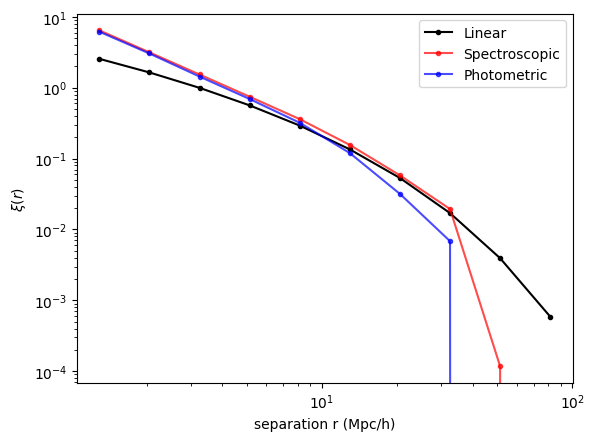

In [84]:
fig, ax = plt.subplots()
ax.plot(ravg, xi_lin, 'k.-', label='Linear')
# ax.plot(ravg, xi_auto_spec, 'r.--', label='Spectroscopic')
# ax.plot(ravg, xi_auto_phot, 'b.--', label='Photometric')
ax.plot(ravg, xix_spec, 'r.-', alpha=0.7, label='Spectroscopic')
ax.plot(ravg, xix_phot, 'b.-', alpha=0.7, label='Photometric')
ax.loglog()
ax.set_xlabel('separation r (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.legend()

In [88]:
# ratios
bs_spec = xix_spec / xi_lin
bs_phot = xix_phot / xi_lin

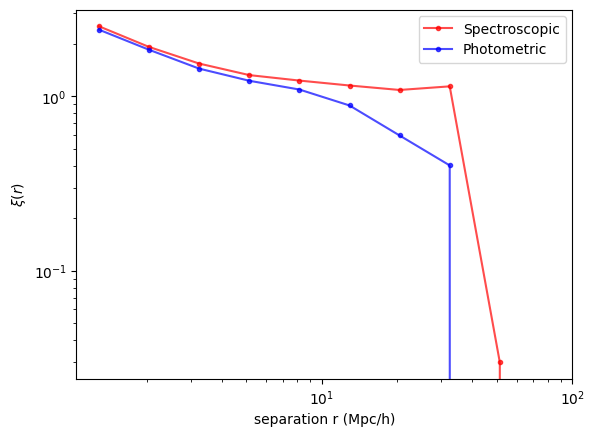

In [89]:
fig, ax = plt.subplots()
ax.plot(ravg, bs_spec, 'r.-', alpha=0.7, label='Spectroscopic')
ax.plot(ravg, bs_phot, 'b.-', alpha=0.7, label='Photometric')
ax.loglog()
ax.set_xlabel('separation r (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.legend()

In [93]:
b_spec = np.mean(bs_spec, where=(bs_spec>0))
b_phot = np.mean(bs_phot, where=(bs_phot>0))
b_spec, b_phot

(1.3290887628143402, 1.2398923814832268)

**convert Cartesian to (RA,Dec)**, setting all LOS positions to the box center

In [16]:
# comoving distance to the box center
r = redshift_to_comov(redshift)
r

<Quantity 1317.92319893 Mpc / littleh>

In [21]:
# full spectroscopic sample
gal_pos = np.copy(gal_pos_spec.value)
gal_pos[:,2] = 0
ra_spec, dec_spec = CartesiantoEquatorial(gal_pos, observer=[0.,0.,r.value])
# photometric sample
gal_pos = np.copy(gal_pos_phot.value)
gal_pos[:,2] = 0
ra_phot, dec_phot = CartesiantoEquatorial(gal_pos, observer=[0.,0.,r.value])

In [22]:
len(ra_spec), len(ra_phot), len(ra_dm)

(24294, 9933, 2441406)

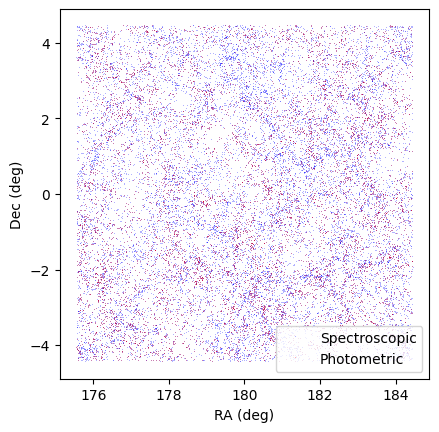

In [24]:
fig, ax = plt.subplots()
kwargs = dict(marker=',', ls='None', alpha=0.3)
ax.plot(ra_spec, dec_spec, c='b', label='Spectroscopic', **kwargs)
ax.plot(ra_phot, dec_phot, c='r', label='Photometric', **kwargs)
ax.set_aspect('equal')
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.legend()